### Import packages

In [1]:
import cantera as ct
import numpy as np
from scipy.integrate import solve_ivp
%matplotlib inline
import matplotlib.pyplot as plt
print(f"Cantera Version: {ct.__version__}")

Cantera Version: 2.6.0


# Make your own: 0-D Perfectly Stirred Reactor

The perfectly stirred reactor (aka "PSR") is defined by a relatively simple set of governing equations, providing an excellent opportunity to demonstrate how we can use Cantera as a "calculator" to provide the terms and variables required for solving a set of equations of our own choosing.

<img src="PSR.png" alt="Cartoon of a Perfectly Stirred Chemical Reactor." style="width: 500px;"/>

The model includes user inputs for the inlet gas conditions (temperature, pressure, composition) and mass flux (typically defined in terms of the residence time $\tau$), some condition for the outlet flow, and an optional heat transfer boundary condition.

## Differential equations:

Given the above, the state of the reactor is defined entirely by the temperature $T$ and the mass densities of each species $\rho_k$.  Note that we could use some combination of mass/mole fractions and pressure or total mass density.  But $\rho = \sum_k \rho_k$ and $Y_k = \frac{\rho_k}{\rho}$ provides sufficient information to fix the reactor state.

### Species mass densities:
The species mass densities change due to three phenomena:
- Flow rate of species in: $\dot{m}_{\rm in} Y_{k,\,{\rm in}}$
- Flow rate of species out: $\dot{m}_{\rm out} Y_{k}$, where $\dot{m}_{\rm out} = K\left(P - P_{\rm out}\right)$ and $Y_k$ is the current composition of the reactor contents. $K$ is a user-defined "valve" coefficient for the outlet flow.
- Homogeneous chemical reactions occuring within the reactor, which occur at a net production molar rate of $\dot \omega_k\,\left[{\rm{unit}}: \frac{{\rm kmol}_k}{\rm m^3 \cdot s}\right]$.

We will pose all state and process variables with respect to the total reactor volume. Hence, for a gas-phase species $k$, we have:

<div class="alert-danger">
    $$ \frac{d\rho_k}{dt} =  \dot{m}^{\prime\prime\prime}_{\rm in}Y_{k,\,{\rm in}} - Y_kK\left(P - P_{\rm out}\right) + W_k \dot \omega_k$$
</div>
where $W_k$ is the species molecular weight $\left[{\rm{unit:}} \frac{\rm kg}{{\rm kmol}_k}\right]$. The term $\dot{m}^{\prime\prime\prime}_{\rm in}$ is inlet mass flow rate per unit volume of the reactor and is calculated as 
<div class="alert-danger">
    $$ \dot{m}^{\prime\prime\prime}_{\rm in} = \frac{\dot m_{\rm in}}{V} = \frac{\rho}{\tau}, $$
</div>
where $\tau$ is the residence time.


### Temperature:
Assuming constant volume and a single-inlet single-exit reactor, the temperature of an ideal gas reactor is described on the [Cantera web page](https://cantera.org/science/reactors.html#ideal-gas-reactor) as:

<div class="alert-danger">
    $$ \frac{dT}{dt} = \frac{1}{\rho c_v}\left(-q + \dot{m}^{\prime\prime\prime}_{\rm in}\left(h_{\rm in} - \sum_k u_kY_{k,{\rm in}}\right) - \frac{p}{\rho}\dot{m}^{\prime\prime\prime}_{\rm out}-\sum_k\omega_k u_k \right)$$
</div>

where, again, all mass flow rates $\dot{m}^{\prime\prime\prime}$ are per unit volume of reactor and $q$ is an optional heat loss term. $u_k$ are species specific internal energies. The outlet mass flow rate is $\dot{m}^{\prime\prime\prime}_{\rm out} = K (P - P_{\rm out})$.

### Define the residual:

In [2]:
def residual(t, SV, gas, inlet, outlet):
    # Initialize the derivative:
    dSVdt = np.zeros_like(SV)

    # Read out current conditions. Convert rho_k into rho and Y_k:
    T = SV[0]
    rho = sum(SV[1:])
    Y_k = SV[1:] / rho

    # Set the Cantera object state:
    gas.TDY = T, rho, Y_k

    # Read out chemical production rates and constant-volume specific heat:
    omega_k = gas.net_production_rates
    c_v = gas.cv_mass

    # Heat loss:
    q = 0

    # dT/dt
    mdot_out = outlet.K*(gas.P - outlet.P)
    dSVdt[0] = (-q + inlet.mdot*(inlet.h - gas.int_energy_mass)
                -gas.P * mdot_out / gas.density_mass
                -np.dot(omega_k, gas.partial_molar_int_energies))/(rho*c_v)

    # d rho_k/dt
    dSVdt[1:] = inlet.mdot*inlet.Y_k - Y_k*outlet.K*(gas.P - outlet.P) + gas.molecular_weights*omega_k

    return dSVdt

### User inputs:

In [3]:
mech_file = 'h2o2.yaml'
t_res = 1e-5  # s
X_init = 'H2:1.0, O2:2.0, AR:4.0'
T_in = 300  # K
P_in = ct.one_atm  # Pa
K_valve = 100

### Instantiate Cantera objects:

In [4]:
gas = ct.Solution(mech_file)
gas.TPX = T_in, P_in, X_init

class inlet:
    h = gas.enthalpy_mass
    Y_k = gas.Y

class outlet:
    K = K_valve
    P = gas.P

# Equilibrate the reactor contents to assure that we have a burning mixture:
gas.equilibrate('HP')

# Calculate the mass flow rate, per unit volume of reactor:
inlet.mdot = gas.density / t_res

### Initialize the Solution Vector and compute solution:

In [5]:
SV_0 = np.hstack([gas.T, gas.density_mass * gas.Y])

# Integrate out to ten residence times, assuming this is long enough to reach steady state.
solution = solve_ivp(residual, [0, 10 * t_res], SV_0, args=(gas, inlet, outlet), method='BDF')

### Some basic plotting:

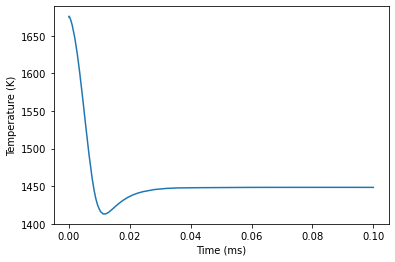

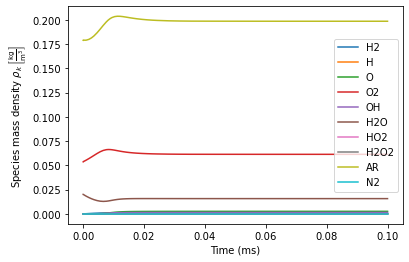

In [6]:
fig, ax = plt.subplots()
ax.plot(solution.t * 1000, solution.y[0])

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Temperature (K)")

fig, ax = plt.subplots()
for j in np.arange(gas.n_species):
    ax.plot(solution.t * 1000, solution.y[1 + j], label=gas.species_names[j])

ax.set_xlabel("Time (ms)")
ax.set_ylabel(r"Species mass density $\rho_k\,\left[\frac{\rm kg}{\rm m^3}\right]$")

ax.legend();

### Challenge question:

The stirred-reactors are typically operated in steady-state. The current model is also used to evaluate the steady-state behavior of the reactor. Can you extend this model to predict a transient behavior? In particular try looking at the effects of imposing time-varying operating conditions such as

a. Reactor volume, $V(t)$

b. Inlet mass flow rate, $\dot m(t)$

c. Reactor temperature, $T(t)$
